In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, cross_val_predict
import random as rm
from sklearn import metrics
from sklearn import impute
import sklearn as sk
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import time as time
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier



In [57]:
df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [68]:
X = df.drop(columns= 'Potability')
y = df['Potability']

In [59]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [60]:
MSE_whole_data = []
#Iterate over the potential optimal values of the hyperparameter 'k' of the KNN algorithm
for k in range(1, 51):
    #Impute the missing values of X_scaled (5380 rows, 765 columns) with the 'k' under consideration
    #Let us call the imputed dataset as 'X_imputed_k'. This dataset has no missing values.
    imputer = KNNImputer(n_neighbors=k)
    X_imputed_k = imputer.fit_transform(X_scaled)
    X_imputed_k = pd.DataFrame(X_imputed_k, columns=X_scaled.columns)
    MSE_multiplied = []
    MSE = []
    #Iterate over each predictor in the data
    for predictor in X_scaled.columns:
        #If there are no missing values in 'predictor', skip the lines below, and continue with the next predictor
        if X_scaled[predictor].isna().sum() == 0:
            continue
        #Remove the observations from 'X_imputed_k', where the 'predictor' has actual missing values.
        #We don't know the true values of those observations for the 'predictor' column, and hence cannot 
        #compute the cross-validation error on them. Let the dataframe with the removed observations be
        #X_imputed_non_missing_k 
        missing_mask = X_scaled[predictor].isna()
        X_imputed_non_missing_k = X_imputed_k.loc[~missing_mask, :]
        #Similarly, remove the observations that have missing values in 'predictor' and call the 
        #resulting Series as 'predictor_nonmissing'
        predictor_nonmissing = X_scaled.loc[~missing_mask, predictor]
        #Consider 'predictor_nonmissing' as the response, and 'X_imputed_non_missing_k' as predictors
        knn = KNeighborsRegressor(n_neighbors=k)
        #Use cross_val_score to compute the 5-fold cross-validated MSE when 'predictor_nonmissing' is 
        #predicted using 'X_imputed_non_missing_k' as the set of predictors, with the KNN model having
        #K = k
        cv_scores= -cross_val_score(knn, X_imputed_non_missing_k, predictor_nonmissing, cv=5, scoring='neg_mean_squared_error')
        #Compute the weighted average of MSEs, and then MSE_whole_data_k as mentioned in steps 6-7 of the announcement
        MSE.append(np.mean(cv_scores))
        MSE_multiplied.append(np.mean(cv_scores) * missing_mask.sum())
    total_se_k = sum(MSE_multiplied)
    MSE_whole_data_k = total_se_k / X_scaled.isnull().sum().sum()
    MSE_whole_data.append(MSE_whole_data_k)

In [61]:
# Find optimal K
optimal_k = np.argmin(MSE_whole_data) + 1
MSE_optimal_k = MSE_whole_data[optimal_k - 1]
print("Optimal K:", optimal_k)
print('MSE for the optimal K:', MSE_optimal_k)

Optimal K: 5
MSE for the optimal K: 0.16072247870117018


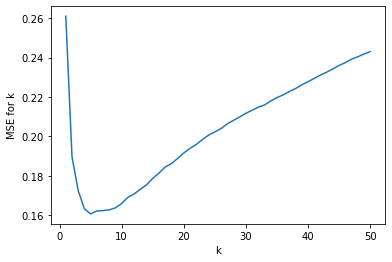

In [62]:
#plot MSEwhole_data_k vs k, and report the (2) optimal K, (3) MSEwhole_data_K for the optimal K, and (4) the option (a) or (b) chosen in step 4.
#Note that this template is for following option (a) in step 4 in the announcement.
# Plot MSEwhole_data_k vs k
plt.plot(range(1, 51), MSE_whole_data)
plt.xlabel('k')
plt.ylabel('MSE for k')
plt.show()

In [64]:
# Select the columns with missing values
columns_with_missing = ['ph', 'Sulfate', "Trihalomethanes"]

# Create a copy of the DataFrame
impute_X = X_scaled.copy()

# Perform KNN imputation with the optimal K value
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed_data = imputer.fit_transform(impute_X[columns_with_missing])

# Update the original DataFrame with the imputed values
X_scaled[columns_with_missing] = imputed_data

In [65]:
X_scaled.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,-0.209627,0.259195,-0.139471,0.112415,0.838973,1.708954,-1.180651,1.273445,-1.286298
1,-2.110818,-2.036414,-0.385987,-0.307694,-0.512637,2.062575,0.270597,-0.622493,0.684218
2,0.638838,0.847665,-0.240047,1.360594,-0.333799,-0.094032,0.781117,0.001472,-1.167365
3,0.775374,0.547651,0.000493,0.592008,0.558106,-0.778830,1.255134,2.098969,0.848412
4,1.261849,-0.464429,-0.460249,-0.363698,-0.570898,-0.343939,-0.824357,-2.126974,0.138786


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 45)

# Do we need to scale values? if so, should they be scaled for train and test? should our test data have imputed values as well, or just train data?

In [70]:
X_train.shape

(2293, 9)

**Going to measure RMSE because larger errors are more important to consider. This is because a small error in a metric may not mean the difference between potable and not, but a large error very well could.**

**Baseline model**

In [71]:
model=DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [72]:
print("Maximum tree depth =", model.get_depth())
print("Maximum leaves =", model.get_n_leaves())

Maximum tree depth = 29
Maximum leaves = 455


In [73]:
model = DecisionTreeClassifier(random_state=1, max_depth=29, max_leaf_nodes=455, max_features=9).fit(X_train, y_train)

# how to print precision for baseline model

**Tuning decision tree**

In [82]:
#Defining parameters and the range of values over which to optimize
param_grid = {    
    'max_depth': range(4, 29, 2),
    'max_leaf_nodes': range(2,455, 10),
    'max_features': range(2, 9)
}

In [83]:
#Grid search to optimize parameter values
start_time = time.time()
skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="precision", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

print('Best accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for precision')
print(grid_search.best_params_)

print("Time taken =", round((time.time() - start_time)), "seconds")


Fitting 5 folds for each of 4186 candidates, totalling 20930 fits
Best accuracy Through Grid Search : 0.668
Best params for precision
{'max_depth': 8, 'max_features': 2, 'max_leaf_nodes': 12}
Time taken = 36 seconds


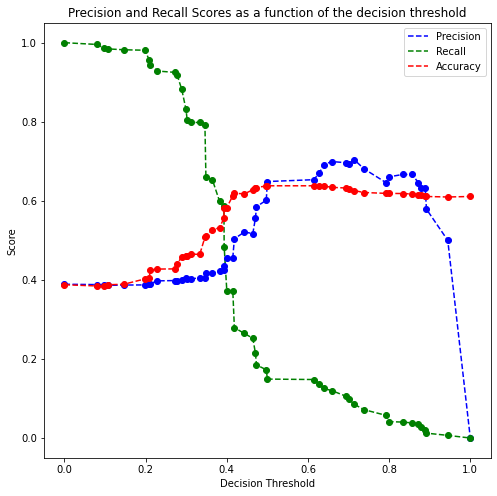

In [84]:
model = DecisionTreeClassifier(random_state=1, max_depth=8, max_leaf_nodes=12, max_features=2).fit(X_train, y_train)

cross_val_ypred=cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth=8,
                                                        max_leaf_nodes=12, max_features=2), X_train,
                                 y_train, cv=5, method='predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:, 1])
acc=np.ndarray(shape=(len(thresholds),))
i=0
for th in thresholds:
    y_pred = cross_val_ypred[:, 1]>th
    y_pred=y_pred.astype(int)
    acc[i]=accuracy_score(y_pred, y_train)
    i = i+1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.plot(thresholds, acc, "r--", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color='blue')
    plt.plot(thresholds, recalls[:-1], "o", color='green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc="best")
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [12]:
all_thresholds = np.concatenate([thresholds.reshape(-1, 1), acc.reshape(-1, 1), r[:-1].reshape(-1,1)], axis=1)
precision_more_than_60=all_thresholds[all_thresholds[:,0]>0.6, :]

In [13]:
all_thresholds

array([[0.        , 0.41862118, 1.        ],
       [0.04347826, 0.42004264, 0.97250859],
       [0.09803922, 0.42430704, 0.96907216],
       [0.11627907, 0.42928216, 0.9604811 ],
       [0.13043478, 0.43425729, 0.95360825],
       [0.14285714, 0.43496802, 0.95360825],
       [0.15384615, 0.43283582, 0.95360825],
       [0.16666667, 0.43781095, 0.94845361],
       [0.17431193, 0.44278607, 0.94501718],
       [0.19230769, 0.4434968 , 0.93127148],
       [0.2       , 0.4434968 , 0.9209622 ],
       [0.21428571, 0.45344705, 0.91924399],
       [0.25      , 0.45273632, 0.90034364],
       [0.26794258, 0.46481876, 0.895189  ],
       [0.275     , 0.47263682, 0.86769759],
       [0.28571429, 0.47334755, 0.83333333],
       [0.30093458, 0.49751244, 0.83333333],
       [0.32291667, 0.50533049, 0.74914089],
       [0.36363636, 0.50461976, 0.73883162],
       [0.38216561, 0.53233831, 0.73539519],
       [0.38888889, 0.53375977, 0.62199313],
       [0.39153439, 0.54228856, 0.62199313],
       [0.

In [14]:
precision_more_than_60[precision_more_than_60.shape[0]-1]

array([1.        , 0.58635394, 0.05498282])

**definitely tune max_features. Don't need to tune n_estimators, just make it high, like around 250. Tuning max_depth and max_lead_nodes is not as important. Don't tune max_features over the number of predictors.**

# Gradient Boosting

>10 0.638 (0.013)
>50 0.644 (0.018)
>100 0.642 (0.017)
>500 0.628 (0.025)
>1000 0.625 (0.024)
>5000 0.620 (0.021)


Text(0.5, 0, 'Number of trees')

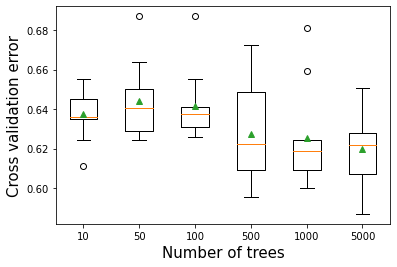

In [87]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = GradientBoostingClassifier(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 0.616 (0.011)
>2 0.637 (0.013)
>3 0.642 (0.017)
>4 0.643 (0.021)
>5 0.640 (0.021)
>6 0.646 (0.017)
>7 0.653 (0.028)
>8 0.638 (0.024)
>9 0.645 (0.017)
>10 0.654 (0.019)
>11 0.646 (0.019)


Text(0.5, 0, 'Depth of each tree')

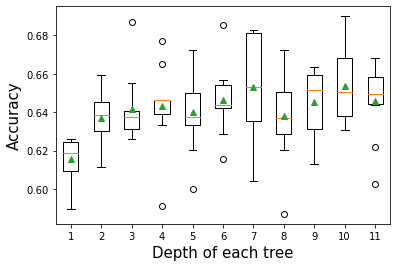

In [89]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,12):
        # define ensemble model
        models[str(i)] = GradientBoostingClassifier(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.1 0.644 (0.028)
>0.2 0.642 (0.031)
>0.3 0.638 (0.025)
>0.4 0.625 (0.026)
>0.5 0.624 (0.030)
>0.6 0.608 (0.048)
>0.7 0.622 (0.032)
>0.8 0.605 (0.029)
>0.9 0.603 (0.019)
>1.0 0.598 (0.028)
>1.1 0.607 (0.032)
>1.2 0.608 (0.029)
>1.3 0.599 (0.022)
>1.4 0.596 (0.025)
>1.5 0.597 (0.030)
>1.6 0.593 (0.033)
>1.7 0.591 (0.033)
>1.8 0.568 (0.033)
>1.9 0.528 (0.047)
>2.0 0.489 (0.070)


Text(0.5, 0, 'Learning rate')

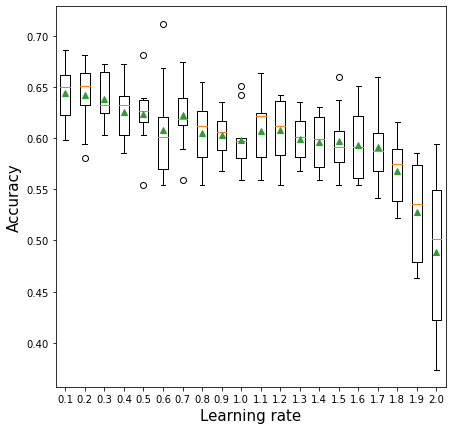

In [90]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = GradientBoostingClassifier(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

In [95]:
start_time = time.time()
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [1,3, 5, 7, 9]
grid['subsample'] = [0.5,1.0]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, verbose = True, scoring = 'precision')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Time taken = ", time.time() - start_time, "seconds")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/catherineerickson/opt/anaconda3/lib/pyt

Best: 0.851429 using {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.5}
Time taken =  85.69590711593628 seconds


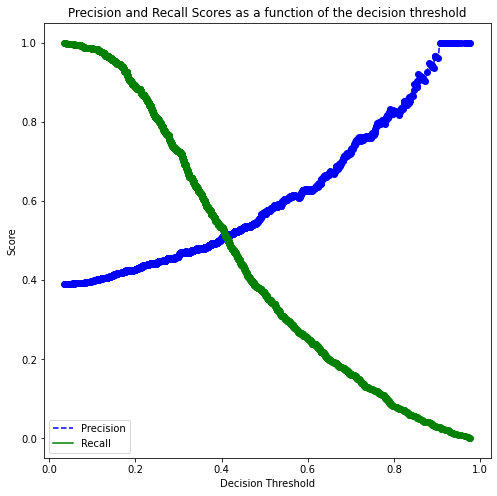

In [96]:
#Model based on the optimal parameters
model = GradientBoostingClassifier(random_state=1,max_depth=5,learning_rate=0.01,subsample=0.5,
                          n_estimators=50).fit(X_train,y_train)

# Note that we are using the cross-validated predicted probabilities, instead of directly using the 
# predicted probabilities on train data, as the model may be overfitting on the train data, and 
# may lead to misleading results
cross_val_ypred = cross_val_predict(GradientBoostingClassifier(random_state=1,max_depth=3,
                                                               learning_rate=0.1,subsample=0.5,
                          n_estimators=200), X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
    
plot_precision_recall_vs_threshold(p, r, thresholds)


In [99]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
precision_more_than_60 = all_thresholds[all_thresholds[:,2]>0.6,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
precision_more_than_60[precision_more_than_60.shape[0]-1]



array([0.3604342 , 0.48201439, 0.60089686])

Accuracy:  64.49643947100712
ROC-AUC:  0.6514220497999497
Precision:  0.5591054313099042
Recall:  0.4533678756476684


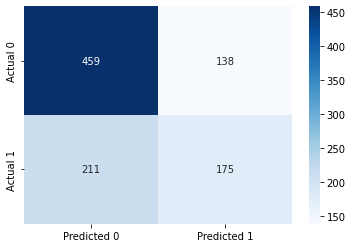

In [111]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.4

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');